## Local Moran's I

### Cluster and Outlier Analysis
#### This notebook identifies specific clusters of high/low salinity and outliers in two study regions: Gulf of Alaska and Panama Pacific Coast.

In [2]:
import arcpy
from arcpy.stats import *
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Setup
arcpy.CheckOutExtension("Spatial")
arcpy.env.overwriteOutput = True
gdb_path = r"C:\Users\Liliana\Documents\ArcGIS\Projects\SalinityDrafting\Salinity_Analysis.gdb"
arcpy.env.workspace = gdb_path

# Load global average
global_raster = "Global_Mean_Salinity_2011_2024"
print(f"✓ Loaded: {global_raster}")

✓ Loaded: Global_Mean_Salinity_2011_2024


### Section 1: Study Regions for Analysis
#### Creating polygons for Gulf of Alaska and Panama regions

In [ ]:
# Create study regions feature class
study_regions = "LocalMoran_StudyRegions"
arcpy.management.CreateFeatureclass(
    gdb_path,
    study_regions,
    "POLYGON",
    spatial_reference=arcpy.SpatialReference(4326)
)

# Add fields
arcpy.management.AddField(study_regions, "Region_Name", "TEXT", field_length=50)
arcpy.management.AddField(study_regions, "Region_Code", "TEXT", field_length=10)

In [ ]:
# Define region coordinates
regions_data = [
    {
        "name": "Gulf_of_Alaska",
        "code": "GOA",
        "coords": [
            [-155, 55],  # Southwest
            [-135, 55],  # Southeast  
            [-135, 62],  # Northeast
            [-155, 62],  # Northwest
            [-155, 55]   # Close
        ],
        "description": "Glacial/river influence region"
    },
    {
        "name": "Panama_Coast",
        "code": "PAN",
        "coords": [
            [-84, 7],    # Southwest
            [-77, 7],    # Southeast
            [-77, 11],   # Northeast  
            [-84, 11],   # Northwest
            [-84, 7]     # Close
        ],
        "description": "Tropical Pacific coast with river influence"
    }
]

# Insert regions
with arcpy.da.InsertCursor(study_regions, ["SHAPE@", "Region_Name", "Region_Code"]) as cursor:
    for region in regions_data:
        polygon = arcpy.Polygon(arcpy.Array([arcpy.Point(*c) for c in region["coords"]]))
        cursor.insertRow([polygon, region["name"], region["code"]])

print(f"✓ Created study regions: {study_regions}")

✓ Created study regions: LocalMoran_StudyRegions


### Section 2: Extract Salinity Points for Analysis
#### Creating point samples within each study region

In [3]:
# Create point samples for each region
all_points = []

for region in regions_data:
    region_name = region["name"]
    region_code = region["code"]
    
    print(f"\nProcessing {region_name} ({region_code})...")
    
    # Create mask for this region
    region_mask = f"temp_{region_code}_mask"
    arcpy.analysis.Select(study_regions, region_mask, f"Region_Code = '{region_code}'")
    
    # Extract raster to points within region
    region_points = f"Salinity_Points_{region_code}"
    
    # First extract raster to region
    region_raster = f"temp_{region_code}_raster"
    extracted = arcpy.sa.ExtractByMask(global_raster, region_mask)
    extracted.save(region_raster)
    
    # Convert to points
    arcpy.conversion.RasterToPoint(region_raster, region_points, "Value")
    
    # Add region identifier
    arcpy.management.AddField(region_points, "Region", "TEXT", field_length=10)
    with arcpy.da.UpdateCursor(region_points, ["Region"]) as cursor:
        for row in cursor:
            row[0] = region_code
            cursor.updateRow(row)
    
    # Count points
    point_count = int(arcpy.management.GetCount(region_points).getOutput(0))
    print(f"  Extracted {point_count:,} salinity points")
    
    # Get statistics
    salinity_vals = []
    with arcpy.da.SearchCursor(region_points, ["grid_code"]) as cursor:
        for row in cursor:
            if row[0] is not None:
                salinity_vals.append(float(row[0]))
    
    if salinity_vals:
        print(f"  Salinity range: {min(salinity_vals):.1f} - {max(salinity_vals):.1f} PSU")
        print(f"  Mean salinity: {np.mean(salinity_vals):.2f} PSU")
    
    all_points.append(region_points)
    
    # Cleanup
    arcpy.management.Delete(region_mask)
    arcpy.management.Delete(region_raster)

print(f"\n✓ Extracted data for {len(regions_data)} regions")


Processing Gulf_of_Alaska (GOA)...
  Extracted 1,224 salinity points
  Salinity range: 31.7 - 32.6 PSU
  Mean salinity: 32.26 PSU

Processing Panama_Coast (PAN)...
  Extracted 219 salinity points
  Salinity range: 31.6 - 35.8 PSU
  Mean salinity: 34.34 PSU

✓ Extracted data for 2 regions


### Section 3: Local Moran's I with ClustersOutliers

In [11]:
local_moran_results = []

for i, region_points in enumerate(all_points):
    region = regions_data[i]
    region_name = region["name"]
    region_code = region["code"]
    
    print(f"\n{'='*60}")
    print(f"LOCAL MORAN'S I: {region_name} ({region_code})")
    print('='*60)
    
    # Run Local Moran's I 
    output_features = f"LocalMoran_{region_code}"
    
    print(f"Running Cluster and Outlier Analysis...")
    
    # let tool choose defaults
    moran_result = arcpy.stats.ClustersOutliers(
        region_points,           # Input points
        "grid_code",            # Field to analyze
        output_features         # Output feature class
    )

    # Get statistics from results
    point_count = int(arcpy.management.GetCount(output_features).getOutput(0))
    
    # Count cluster types
    cluster_counts = {"HH": 0, "LL": 0, "HL": 0, "LH": 0, "NS": 0, "NN": 0}
    with arcpy.da.SearchCursor(output_features, ["COType"]) as cursor:
        for row in cursor:
            cotype = row[0] if row[0] else "NS"  # NS = Not Significant
            cluster_counts[cotype] = cluster_counts.get(cotype, 0) + 1
    
    print(f"✓ Analysis complete: {output_features}")
    print(f"  Total features: {point_count:,}")
    print(f"  Cluster types:")
    print(f"    HH (High-High): {cluster_counts['HH']:,} - Clusters of high salinity")
    print(f"    LL (Low-Low):   {cluster_counts['LL']:,} - Clusters of low salinity")
    print(f"    HL (High-Low):  {cluster_counts['HL']:,} - High salinity outliers")
    print(f"    LH (Low-High):  {cluster_counts['LH']:,} - Low salinity outliers")
    print(f"    NS (Not Sig):   {cluster_counts['NS']:,} - Not statistically significant")
    
    # Calculate percentages
    significant_count = sum([cluster_counts[t] for t in ["HH", "LL", "HL", "LH"]])
    if point_count > 0:
        sig_percent = (significant_count / point_count) * 100
        print(f"  Significant features: {significant_count:,} ({sig_percent:.1f}%)")
    
    # Store results
    local_moran_results.append({
        "region": region_name,
        "code": region_code,
        "output": output_features,
        "counts": cluster_counts,
        "total": point_count
    })

print(f"\n✓ Local Moran's I completed for all regions")


LOCAL MORAN'S I: Gulf_of_Alaska (GOA)
Running Cluster and Outlier Analysis...
✓ Analysis complete: LocalMoran_GOA
  Total features: 1,224
  Cluster types:
    HH (High-High): 277 - Clusters of high salinity
    LL (Low-Low):   160 - Clusters of low salinity
    HL (High-Low):  0 - High salinity outliers
    LH (Low-High):  0 - Low salinity outliers
    NS (Not Sig):   787 - Not statistically significant
  Significant features: 437 (35.7%)

LOCAL MORAN'S I: Panama_Coast (PAN)
Running Cluster and Outlier Analysis...
✓ Analysis complete: LocalMoran_PAN
  Total features: 219
  Cluster types:
    HH (High-High): 35 - Clusters of high salinity
    LL (Low-Low):   59 - Clusters of low salinity
    HL (High-Low):  0 - High salinity outliers
    LH (Low-High):  0 - Low salinity outliers
    NS (Not Sig):   125 - Not statistically significant
  Significant features: 94 (42.9%)

✓ Local Moran's I completed for all regions


### Visualizations of results
##### (My dad helped with this code EXTENSIVELY)


Creating visualizations...


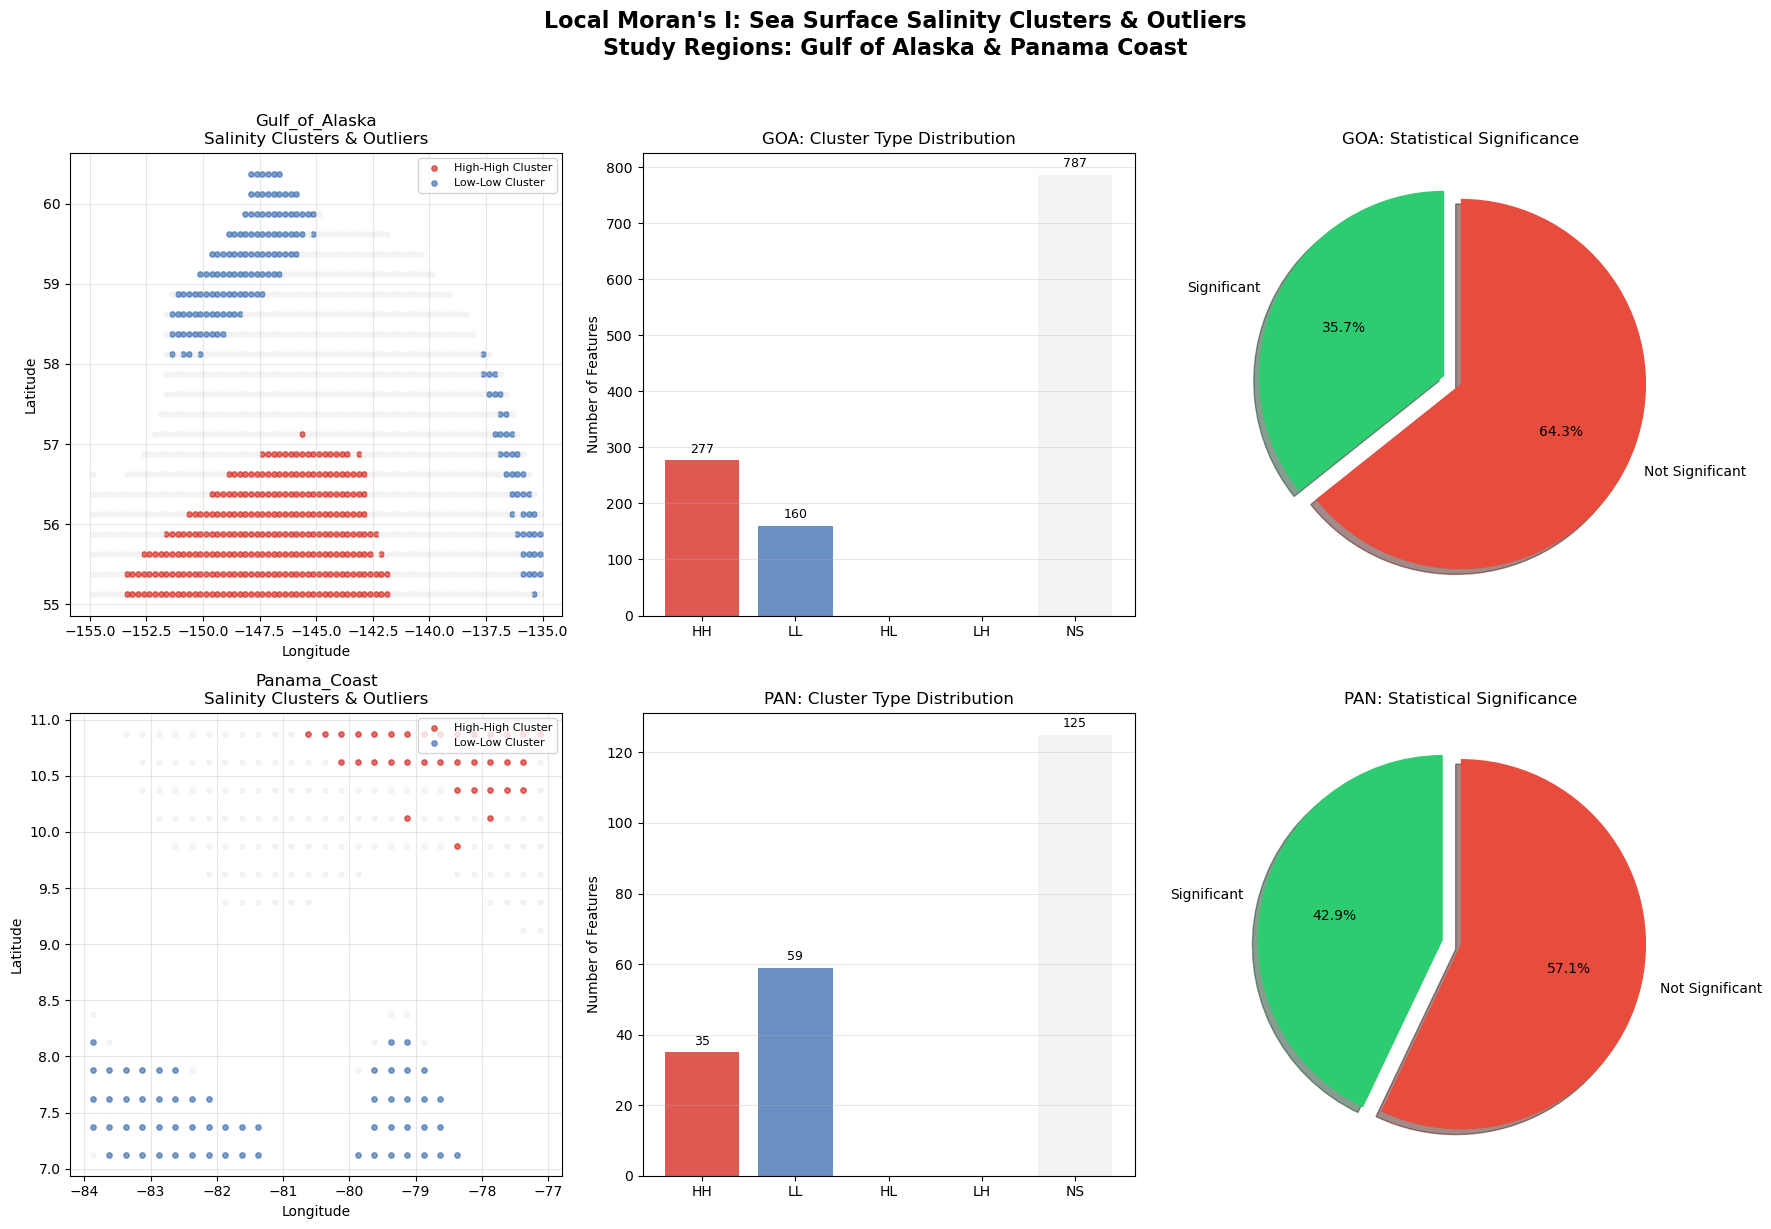

✓ Visualization saved to desktop: local_moran_results.png


In [12]:
print("\nCreating visualizations...")

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Local Moran\'s I: Sea Surface Salinity Clusters & Outliers\nStudy Regions: Gulf of Alaska & Panama Coast', 
             fontsize=16, fontweight='bold', y=1.02)

# Color scheme for cluster types
cluster_colors = {
    "HH": "#d73027",  # Red - High-High clusters
    "LL": "#4575b4",  # Blue - Low-Low clusters  
    "HL": "#fee090",  # Yellow - High-Low outliers
    "LH": "#91bfdb",  # Light blue - Low-High outliers
    "NS": "#f0f0f0",  # Gray - Not significant
    "NN": "#ffffff"   # White - No neighbors
}

cluster_labels = {
    "HH": "High-High Cluster",
    "LL": "Low-Low Cluster",
    "HL": "High-Low Outlier",
    "LH": "Low-High Outlier",
    "NS": "Not Significant",
    "NN": "No Neighbors"
}

# Process each region
for idx, result in enumerate(local_moran_results):
    region_name = result["region"]
    region_code = result["code"]
    output_fc = result["output"]
    
    # Determine subplot position
    row = idx  # 0 = Gulf of Alaska, 1 = Panama
    col_offset = 0
    
    # Plot 1: Map of clusters
    ax_map = axes[row, 0]
    
    # Read data for mapping
    coords = []
    cotypes = []
    salinity_vals = []
    
    with arcpy.da.SearchCursor(output_fc, ["SHAPE@XY", "COType", "grid_code"]) as cursor:
        for row_data in cursor:
            x, y = row_data[0]
            cotype = row_data[1] if row_data[1] else "NS"
            salinity = row_data[2] if row_data[2] else 0
            
            coords.append((x, y))
            cotypes.append(cotype)
            salinity_vals.append(salinity)
    
    if coords:
        # Convert to arrays
        x_coords = [c[0] for c in coords]
        y_coords = [c[1] for c in coords]
        
        # Plot each cluster type with appropriate color
        for cotype in ["HH", "LL", "HL", "LH", "NS"]:
            mask = [c == cotype for c in cotypes]
            if any(mask):
                x_subset = [x for x, m in zip(x_coords, mask) if m]
                y_subset = [y for y, m in zip(y_coords, mask) if m]
                
                ax_map.scatter(x_subset, y_subset, 
                             color=cluster_colors[cotype],
                             s=15, alpha=0.7,
                             label=cluster_labels[cotype] if cotype in ["HH", "LL", "HL", "LH"] else None)
        
        ax_map.set_title(f"{region_name}\nSalinity Clusters & Outliers", fontsize=12)
        ax_map.set_xlabel("Longitude", fontsize=10)
        ax_map.set_ylabel("Latitude", fontsize=10)
        ax_map.grid(True, alpha=0.3)
        ax_map.legend(loc='upper right', fontsize=8)
    
    # Plot 2: Bar chart of cluster counts
    ax_bar = axes[row, 1]
    
    counts = result["counts"]
    categories = ["HH", "LL", "HL", "LH", "NS"]
    values = [counts.get(cat, 0) for cat in categories]
    colors = [cluster_colors[cat] for cat in categories]
    
    bars = ax_bar.bar(categories, values, color=colors, alpha=0.8)
    ax_bar.set_title(f"{region_code}: Cluster Type Distribution", fontsize=12)
    ax_bar.set_ylabel("Number of Features", fontsize=10)
    ax_bar.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax_bar.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Pie chart of significant vs non-significant
    ax_pie = axes[row, 2]
    
    sig_count = sum([counts.get(t, 0) for t in ["HH", "LL", "HL", "LH"]])
    ns_count = counts.get("NS", 0)
    
    if sig_count + ns_count > 0:
        sizes = [sig_count, ns_count]
        labels = ['Significant', 'Not Significant']
        colors_pie = ['#2ecc71', '#e74c3c']
        explode = (0.1, 0)  # explode significant slice
        
        ax_pie.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                  autopct='%1.1f%%', shadow=True, startangle=90)
        ax_pie.set_title(f"{region_code}: Statistical Significance", fontsize=12)
    else:
        ax_pie.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
        ax_pie.set_title(f"{region_code}: No Results", fontsize=12)

plt.tight_layout()
plt.savefig(r"C:\Users\Liliana\Desktop\local_moran_results.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualization saved to desktop: local_moran_results.png")